In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *

np.random.seed(1)

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 512  # object size in each dimension

noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
npos = 49  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = 1200+2*pad

show = True

flg = f'{n}_{1}_{npos}_{z1c}_{noise}_code'
path = f'/data2/vnikitin/nfp_codes'
rho=0.1

## Read data

In [3]:
data00 = np.zeros([1, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
print(f'{path}/data/data_{0}_{flg}.tiff')
for k in range(npos):
    data00[:, k] = read_tiff(f'{path}/data/data_{k}_{flg}.tiff')[:1]
for k in range(npos):
    ref0[:, k] = read_tiff(f'{path}/data/ref_{k}_{flg}.tiff')[:]
code = np.load(f'{path}/data/code_{flg}.npy')
shifts = np.load(f'{path}/data/shifts_code_{flg}.npy')[:, :npos]

dxchange.write_tiff(np.abs(code),'code_abs.tiff')
dxchange.write_tiff(np.angle(code),'code_angle.tiff')


/data2/vnikitin/nfp_codes/data/data_0_512_1_49_-0.0195_0_code.tiff


# Construct operators


In [4]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir#cp.pad(psir,((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))                
    return psi

def Sop(psi,shifts):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data,shifts):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts = cp.array(shifts)
arr2 = Sop(arr1,shifts*rho)
arr3 = STop(arr2,shifts*rho)

arr4 = Lop(arr2)
arr5 = LTop(arr4)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')



(24916900+1.8835697174072266j)==
(24916900+8.200871093322348e-09j)
(15695109-0.16330289840698242j)==
(15695109+1.0846337318071164e-05j)


#### Reconstruction with the CG (Carlsson) with Hessians

#### $$\nabla F=2 \left(L^*\left( L(M(q_0,\psi_0,\boldsymbol{x}_0))-\tilde D\right)\right).$$
#### where $$\tilde D = D \frac{L(M(q_0,\psi_0,\boldsymbol{x}_0))}{|L(M(q_0,\psi_0,\boldsymbol{x}_0))|}$$



In [5]:
def gradientF(psi,q,x,d):
    Lpsi = Lop(Sop(psi,x*rho)*q)
    td = d*(Lpsi/cp.abs(Lpsi))
    res = 2*LTop(Lpsi - td)
    return res

#### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z)))\right\rangle.$$
#### $$l_0=L(x_0)/|L(x_0)|$$
#### $$d_0=d/|L(x_0)|$$


In [6]:
def hessianF(hpsi,hpsi1,hpsi2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)    
    l0 = Lpsi/cp.abs(Lpsi)
    d0 = data/cp.abs(Lpsi)
    v1 = cp.sum((1-d0)*cp.conj(cp.real(Lpsi1*cp.conj(Lpsi2))))
    v2 = cp.sum(d0*cp.conj(
        cp.real(cp.conj(l0)*Lpsi1)*
        cp.real(cp.conj(l0)*Lpsi2)))
    return 2*(v1+v2)

##### $$\nabla_{\psi} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=S_{\boldsymbol{x}_{0}}^*\left(\overline{J(q_0)}\cdot \nabla F\right).$$
##### $$\nabla_{q} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=J^*\left( \overline{S_{\boldsymbol{x}_{0}}(\psi_0)}\cdot \nabla F\right).$$
##### $$\nabla_{\boldsymbol{x}_0} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \nabla F,   C(\mathcal{F}^{-1}(\xi_1 e^{ \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \nabla F,C(\mathcal{F}^{-1}(\xi_2 e^{ \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$

### Adjustments
#### $$ \xi = -2\pi i \tilde{\xi}$$
#### new operator $$T_{\psi,w}(x) = C(\mathcal{F}^{-1}(w e^{ \boldsymbol{x}_{0}\cdot \boldsymbol{\xi}}\hat{\psi_0}))$$




In [7]:
def _Tw0(psi, x, w, ptype='constant'):
    res = psi.copy()
    n = res.shape[-1]        
    p = cp.pad(x, (0, res.shape[0]-x.shape[0]))    
    res = cp.pad(res, ((0, 0), (n//2, n//2), (n//2, n//2)), ptype)
    
    xi1 = cp.fft.fftfreq(2*n).astype('float32')
    xi1 = xi1*(-2*cp.pi*1j)*rho#!!!!
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    pp = cp.exp(xi1*p[:, 0, None, None]+xi2*p[:, 1, None, None])
    
    pp = pp*w

    res = cp.fft.ifft2(pp*cp.fft.fft2(res))   
    res = res[:, n//2:-n//2, n//2:-n//2]
    return res

def Twop(psi,x,w):
    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()            
        psir = _Tw0(psir, x[:, i],w)
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]        
    return data

def gradients(psi,q,x,d):
    gradF = gradientF(psi,q,x,d)

    gradpsi = STop(cp.conj(q)*gradF,x*rho)
    gradq = cp.sum(cp.conj(Sop(psi,x*rho))*gradF,axis=1)
    

    
    n = psi.shape[-1]
    xi1 = cp.fft.fftfreq(2*n).astype('float32')    
    xi1 = xi1*(-2*cp.pi*1j)*rho##!!!

    [xi2, xi1] = cp.meshgrid(xi1, xi1)
  
    tksi1 = Twop(psi,x,xi1)
    tksi2 = Twop(psi,x,xi2)
    gradx = cp.zeros([1,npos,2],dtype='float32')
    gradx[:,:,0] = cp.real(cp.sum(cp.conj(q)*gradF*cp.conj(tksi1),axis=(2,3)))
    gradx[:,:,1] = cp.real(cp.sum(cp.conj(q)*gradF*cp.conj(tksi2),axis=(2,3)))



    return gradpsi,gradq,gradx

#### $$ D T_\psi|_{{\boldsymbol{z}_0}}(\Delta \boldsymbol{z})=C(\mathcal{F}^{-1}(\xi_1 e^{ \boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))\Delta {z}_{1}+C(\mathcal{F}^{-1}(\xi_2 e^{ \boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))\Delta {z}_2$$

In [8]:
def DT(psi,x,dx):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')
    xi1=xi1*(-2*cp.pi*1j)*rho##!!!
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    tksi1 = Twop(psi,x,xi1)
    tksi2 = Twop(psi,x,xi2)
    res = tksi1*dx[:,:,0,None,None]+tksi2*dx[:,:,1,None,None]
    return res

#### $$D^2{T_\psi}|_{{\boldsymbol{z}_0}}(\Delta\boldsymbol{z},\Delta\boldsymbol{w})=$$
#### $$\Delta {z}_{1}\Delta {w}_{1} C(\mathcal{F}^{-1}(\xi_1^2 e^{ \boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi})) +(\Delta {z}_{1}\Delta {w}_{2} +$$
#### $$ \Delta {w}_{1}\Delta {z}_{2})C(\mathcal{F}^{-1}(\xi_1\xi_2 e^{ \boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))+\Delta {z}_{2}\Delta {w}_{2} C(\mathcal{F}^{-1}(\xi_2^2 e^{ \boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))$$

In [9]:
def D2T(psi,x,dx1,dx2):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')
    xi1=xi1*(-2*cp.pi*1j)*rho##!!!
    [xi2,xi1] = cp.meshgrid(xi1, xi1)

    dx11 = dx1[:,:,:,None,None] 
    dx22 = dx2[:,:,:,None,None] 
    res = dx11[:,:,0]*dx22[:,:,0]*Twop(psi,x,xi1**2)+ \
         (dx11[:,:,0]*dx22[:,:,1]+dx11[:,:,1]*dx22[:,:,0])*Twop(psi,x,xi1*xi2)+ \
          dx11[:,:,1]*dx22[:,:,1]*Twop(psi,x,xi2**2)
    return res

#### $$ DM|_{(q_0,\psi_0,\boldsymbol{x})}(\Delta q, \Delta \psi,\Delta\boldsymbol{x})=$$
#### $$ \Big(\Delta q\cdot T_{\psi_0}({\boldsymbol{x}_{0,k}})+ q_0\cdot \big(T_{\Delta \psi}({\boldsymbol{x}_{0,k}})+  DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k)\big) \Big)_{k=1}^K=$$
#### $$ J(\Delta q)\cdot S_{\boldsymbol{x}_{0,k}}(\psi_0)+ J(q_0)\cdot S_{\boldsymbol{x}_{0}}{(\Delta \psi)}+  \Big(q_0\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k) \Big)_{k=1}^K$$


In [10]:
def DM(psi,q,x,dpsi,dq,dx):
    res= dq*Sop(psi,x*rho)+q*(Sop(dpsi,x*rho)+DT(psi,x,dx))   
    return res

##### $$ D^2M|_{(q_0,\psi_0,\boldsymbol{x})}\big((\Delta q^{(1)}, \Delta \psi^{(1)},\Delta\boldsymbol{x}^{(1)}),(\Delta q^{(2)}, \Delta \psi^{(2)},\Delta\boldsymbol{x}^{(2)})\big)= $$
##### $$\Big( q_0\cdot DT_{\Delta\psi^{(1)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+q_0\cdot DT_{\Delta\psi^{(2)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})+ q_0\cdot D^2{T_\psi}|_{{\boldsymbol{x}_0}}(\Delta\boldsymbol{x}^{(1)},\Delta\boldsymbol{x}^{(2)})+$$
##### $$\Delta q^{(1)}\cdot T_{\Delta \psi^{(2)}}({\boldsymbol{x}_{0,k}})+\Delta q^{(2)}\cdot T_{\Delta \psi^{(1)}}({\boldsymbol{x}_{0,k}})+ $$
##### $$\Delta q^{(1)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+\Delta q^{(2)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})\Big)_{k=1}^K.$$


In [11]:
def D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2):    
    res =  q*DT(dpsi1,x,dx2) + q*DT(dpsi2,x,dx1) + q*D2T(psi,x,dx1,dx2)  
    res += dq1*Sop(dpsi2,x*rho) + dq2*Sop(dpsi1,x*rho) 
    res += dq1*DT(psi,x,dx2) + dq2*DT(psi,x,dx1)
    return res

##### $$\mathcal{H}^G|_{ (q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)=$$
##### $$\Big\langle \nabla F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}, D^2M|_{(q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)\Big\rangle +$$
##### $$\mathcal{H}^F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}\Big(DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big).$$

In [12]:
def hessian2(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2,data):
    gradF = gradientF(psi,q,x,data)

    res = cp.real(cp.sum(gradF*cp.conj(D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2))))
    res += hessianF(Sop(psi,x*rho)*q, DM(psi,q,x,dpsi1,dq1,dx1),DM(psi,q,x,dpsi2,dq2,dx2),data) 
        
    return res

In [13]:
def rec_init(ref0,data00,shifts):
    ref0 = cp.array(ref0)
    data00 = cp.array(data00)

    rdata = data00/ref0
    # mshow((rdata)[0,0],show,vmax=2)
    recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
    recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        r = multiPaganin(rdata[:,j:j+1],
                            distances[j:j+1], wavelength, voxelsize,  24.05, 5e-2)    
        rr = r*0+1 # to compensate for overlap
        r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        recMultiPaganin[:,j] = ST(r,shifts[:,j])
        recMultiPaganinr[:,j] = ST(rr,shifts[:,j])
        
    recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
    recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

    # avoid division by 0
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr
    recMultiPaganin = cp.exp(1j*recMultiPaganin)

    # mshow_polar(recMultiPaganin[0],show)
    # mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)
    return recMultiPaganin


In [14]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

# minimization functional
def minf(fpsi,data):
    f = np.linalg.norm(np.abs(fpsi)-data)**2
    return f

def plot_debug1(psi,prb,shifts,gradshift,data):
    err = cp.zeros(16)
    err1 = cp.zeros(16)
    tt=cp.linspace(0,1,16)
    
    for it in range(16):
        st = shifts+(shifts_gt-shifts)*tt[it]
        ft = Lop(Sop(psi,st*rho)*prb)
        err[it] = minf(ft,data)
        b = cp.sum(cp.real(gradshift*cp.conj(shifts_gt-shifts)))
        a = minf(ft,data)
        err1[it] = a+(tt[it])*b+0.5*tt[it]**2*hessian2(psi,prb,shifts,
                                                        psi*0,prb*0,shifts_gt-shifts,
                                                        psi*0,prb*0,shifts_gt-shifts,data)
    plt.plot(err.get(),label='function values')
    plt.plot(err1.get(),label='Taylor approx')
    plt.legend()
    plt.show()

def plot_debug2(psi,prb,shifts,etapsi,etaprb,etashift,top,bottom,gammah,data):
    npp = 17
    errt = np.zeros(npp*2)
    errt2 = np.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(gammah*k/(npp-1))*etapsi
        prbt = prb+(gammah*k/(npp-1))*etaprb
        shiftst = shifts+(gammah*k/(npp-1))*etashift
        fpsit = Lop(Sop(psit,shiftst*rho)*prbt)
        errt[k] = minf(fpsit,data)    

    t = gammah*(cp.arange(2*npp))/(npp-1)
    errt2 = minf(Lop(Sop(psi,shifts*rho)*prb),data)-top*t+0.5*bottom*t**2
    
    plt.plot(gammah.get()*np.arange(2*npp)/(npp-1),errt,'.')
    plt.plot(gammah.get()*np.arange(2*npp)/(npp-1),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts):
    plt.plot((shifts_gt[0,:,0]).get()-(shifts[0,:,0]).get(),'r.')
    plt.plot((shifts_gt[0,:,1]).get()-(shifts[0,:,1]).get(),'b.')
    plt.show()

/tmp/ipykernel_1441851/3191795650.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts[:,j])
/tmp/ipykernel_1441851/3191795650.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts[:,j])


(1, 640, 640)
ITERATION 0
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(2277.4644, dtype=float32)


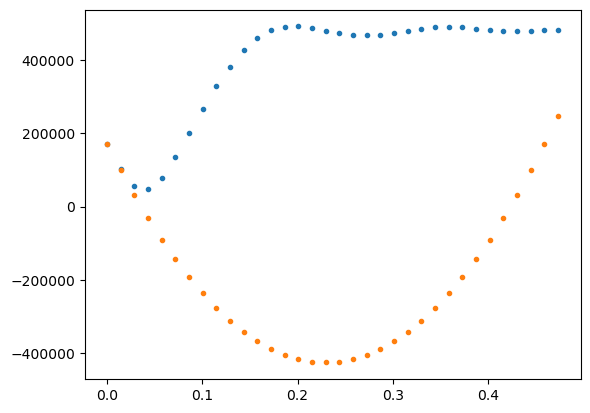

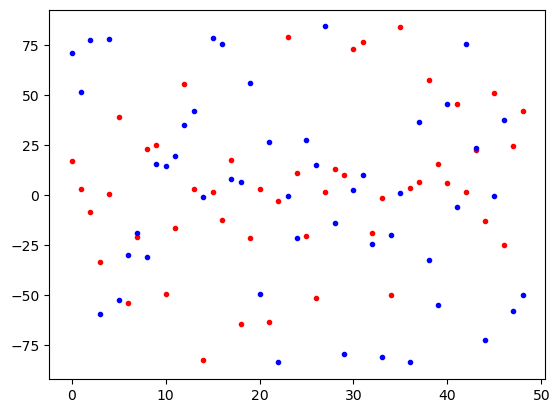

0) gammah=array(0.22966766, dtype=float32), err=4.79883e+05
ITERATION 1
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(1082.9272, dtype=float32)


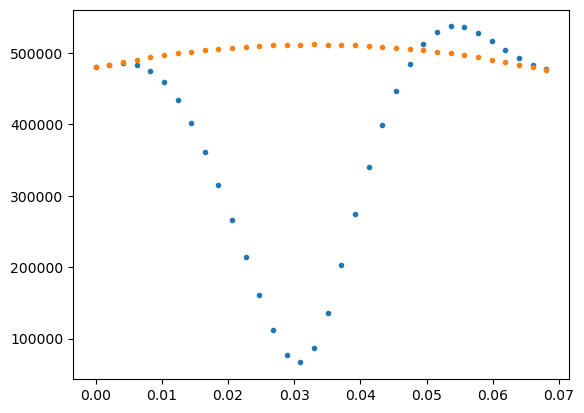

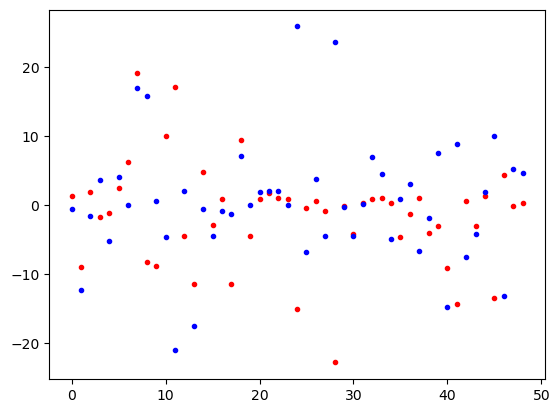

1) gammah=array(0.03301622, dtype=float32), err=8.69362e+04
ITERATION 2
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(1730.1488, dtype=float32)


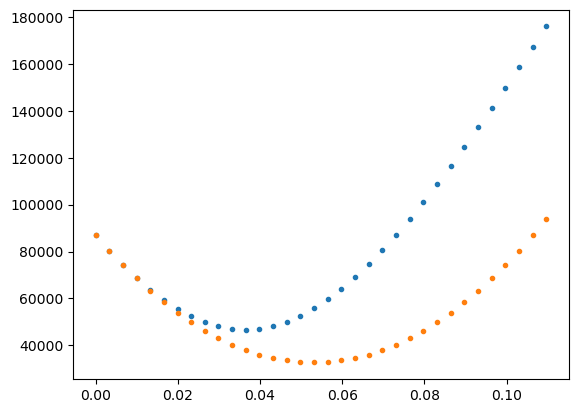

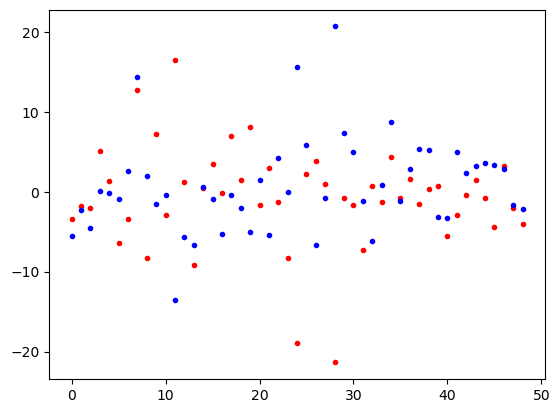

2) gammah=array(0.05317385, dtype=float32), err=5.58232e+04
ITERATION 3
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(1632.826, dtype=float32)


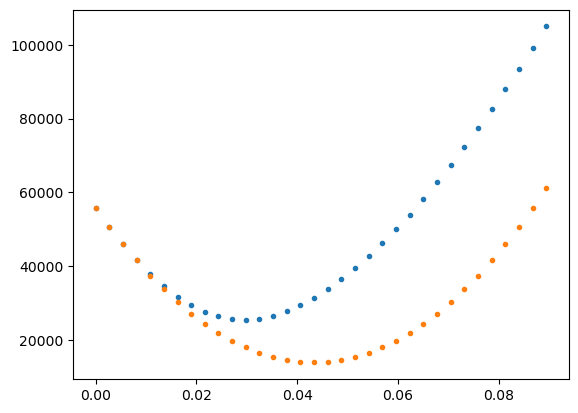

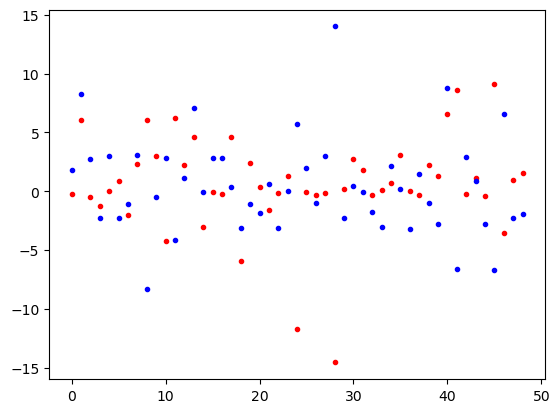

3) gammah=array(0.04335966, dtype=float32), err=3.14430e+04
ITERATION 4
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(1321.907, dtype=float32)


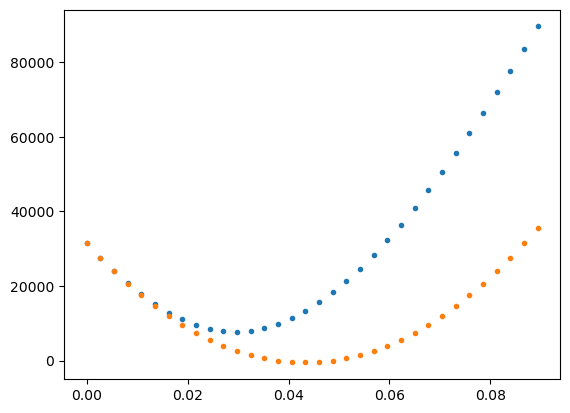

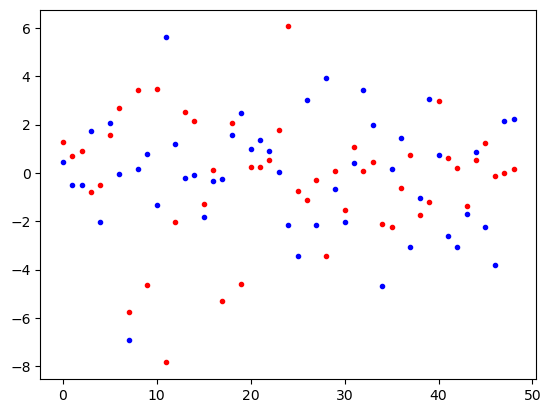

4) gammah=array(0.04331814, dtype=float32), err=1.33324e+04
ITERATION 5
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(1042.9656, dtype=float32)


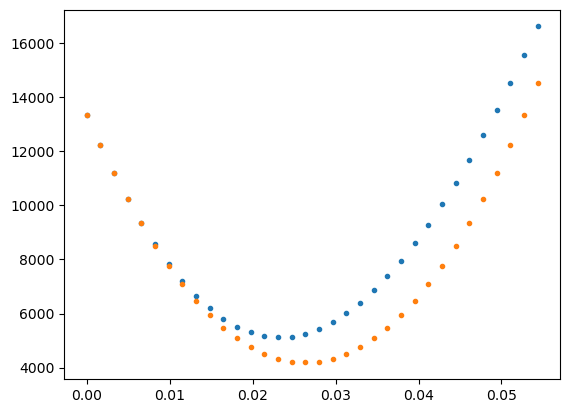

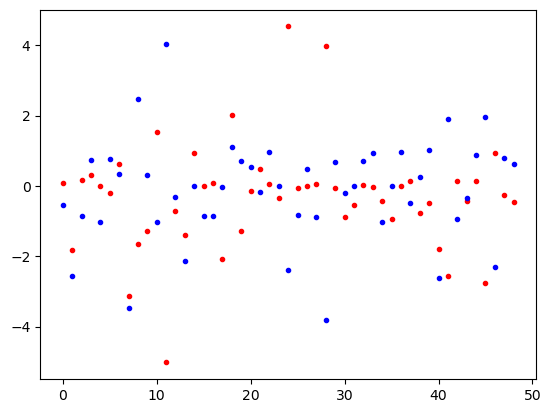

5) gammah=array(0.02635006, dtype=float32), err=5.24864e+03
ITERATION 6
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(674.496, dtype=float32)


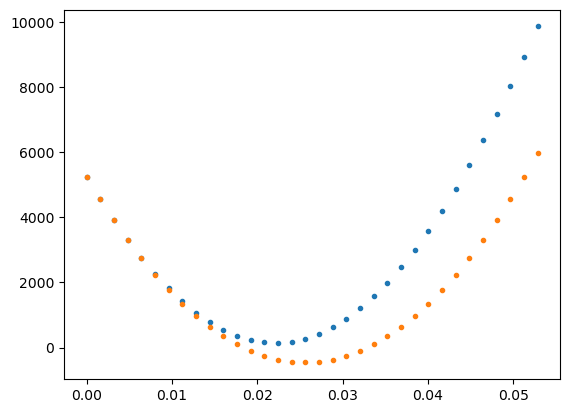

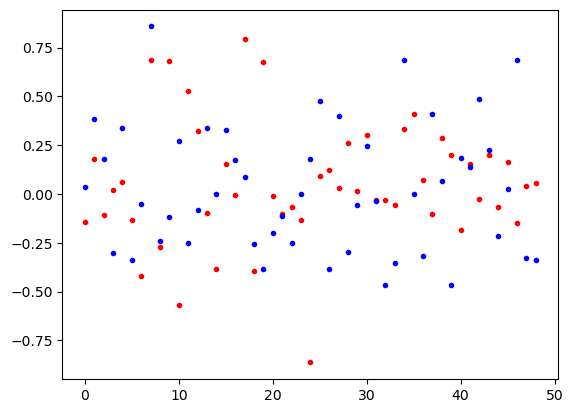

6) gammah=array(0.02561587, dtype=float32), err=2.74966e+02
ITERATION 7
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(156.43776, dtype=float32)


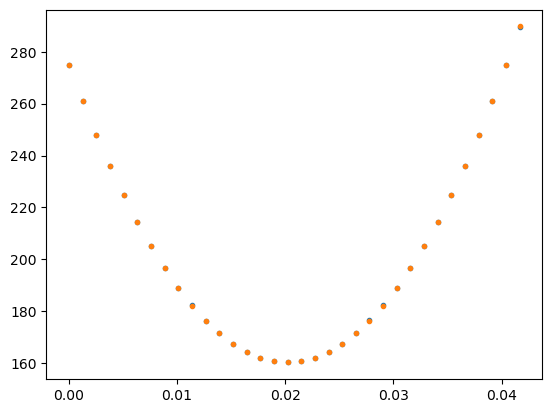

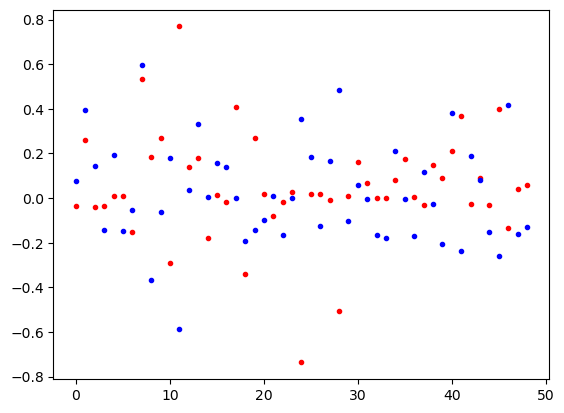

7) gammah=array(0.02021009, dtype=float32), err=1.60332e+02
ITERATION 8
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(114.48071, dtype=float32)


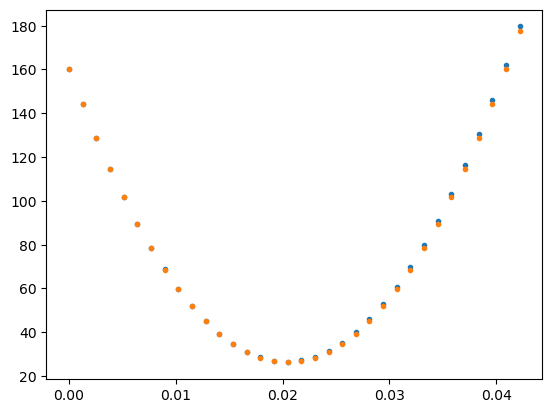

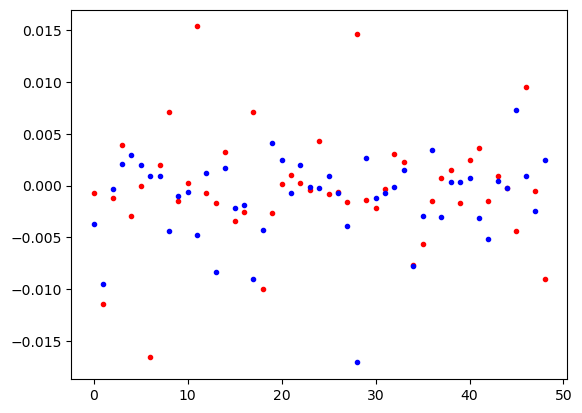

8) gammah=array(0.02046602, dtype=float32), err=2.65755e+01
ITERATION 9
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(2.2328444, dtype=float32)


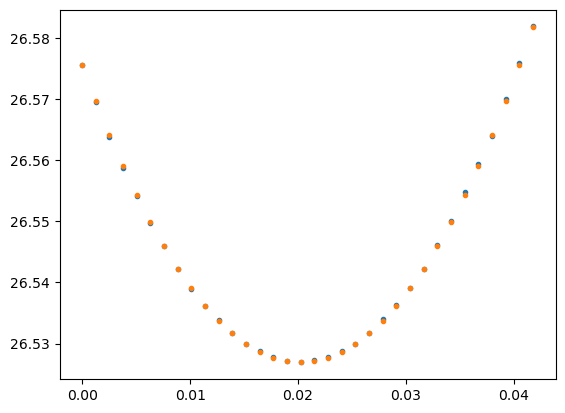

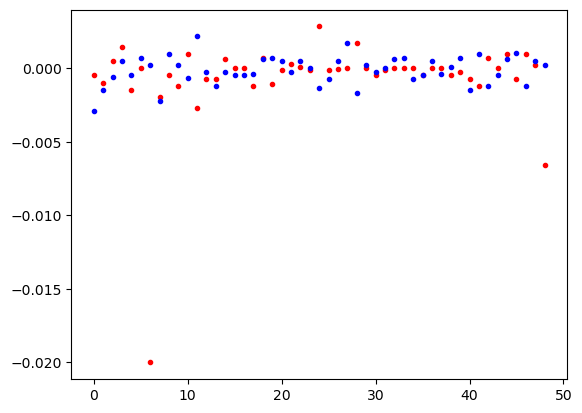

9) gammah=array(0.02024467, dtype=float32), err=2.65270e+01
ITERATION 10
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(0.40985045, dtype=float32)


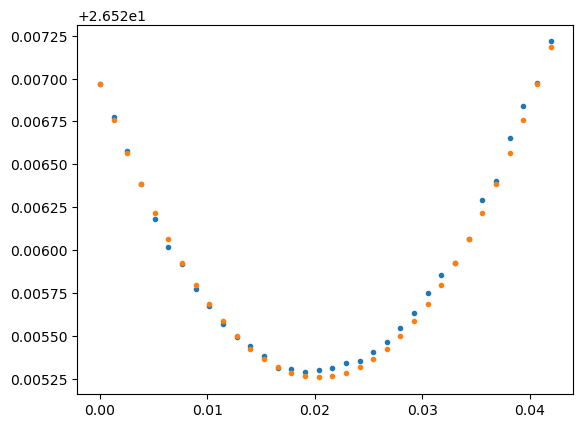

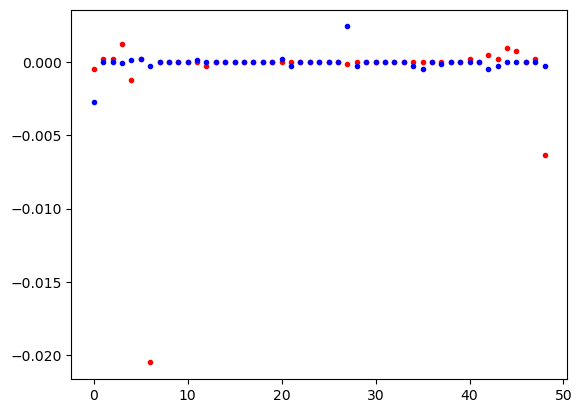

10) gammah=array(0.02035129, dtype=float32), err=2.65253e+01
ITERATION 11
cp.linalg.norm(gradpsi)=array(0., dtype=float32)
 cp.linalg.norm(gradprb)=array(0., dtype=float32)
 cp.linalg.norm(gradshift)=array(0.04730535, dtype=float32)


KeyboardInterrupt: 

In [16]:

def cg_holo(data,ref, init_psi,init_prb,init_shifts, pars):

    data = np.sqrt(data)
    ref = np.sqrt(ref)
    psi = init_psi.copy()
    prb = init_prb.copy()
    shifts = init_shifts.copy()

    conv = np.zeros(pars['niter'])
    gammaha = np.zeros(pars['niter'])    
    
    for i in range(pars['niter']):                                                
        print(f"ITERATION {i}")
        
        gradpsi,gradprb,gradshift = gradients(psi,prb,shifts,data)
        # gradpsi[:] = 0
        # gradprb[:] = 0
        # gradshift[:]=0
        print(f'{cp.linalg.norm(gradpsi)=}\n {cp.linalg.norm(gradprb)=}\n {cp.linalg.norm(gradshift)=}')        
        
        # plot_debug1(psi,prb,shifts,gradshift,data)
        
        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
            etashift = -gradshift
        else:        
            beta = hessian2(psi,prb,shifts,gradpsi,gradprb,gradshift,etapsi,etaprb,etashift,data)/\
                   hessian2(psi,prb,shifts, etapsi, etaprb, etashift,etapsi,etaprb,etashift,data)                        
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb
            etashift = -gradshift + beta*etashift            
        #top
        top = -(cp.sum(cp.real(gradpsi*cp.conj(etapsi)))+
                cp.sum(cp.real(gradprb*cp.conj(etaprb)))+
                cp.sum(cp.real(gradshift*cp.conj(etashift))))        
        bottom = hessian2(psi,prb,shifts,etapsi,etaprb,etashift,
                                         etapsi,etaprb,etashift,data)
        gammah = top/bottom        
        
        plot_debug2(psi,prb,shifts,etapsi,etaprb,etashift,top,bottom,gammah,data)
        
        psi += gammah*etapsi
        prb += gammah*etaprb
        shifts += gammah*etashift
        
        plot_debug3(shifts)

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi,shifts*rho)*prb)
            err = minf(fpsi,data)
            conv[i] = err
            gammaha[i] = gammah
            print(f'{i}) {gammah=}, {err=:1.5e}')
        
    return psi,prb,conv,gammaha

rec_psi = cp.ones([1,ne,ne],dtype='complex64')
data = cp.array(data00.copy())
ref = cp.array(ref0.copy())
rec_shifts = cp.array(shifts/rho)
shifts_gt = cp.array(shifts/rho)

rec_shifts[:,:,:] += 4*(cp.random.random(rec_shifts.shape)-0.5)/rho
# rec_shifts[:,0,0]+=10/rho
# rec_shifts=cp.array(np.load('rec_shifts.npy'))   

rec_psi = rec_init(ref0,data00,rec_shifts*rho)
rec_prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
pars = {'niter': 64, 'err_step': 1, 'vis_step': -1}

# rec_prb = cp.array(np.load(f'{path}/data/prb_{flg}.npy'))
# print(rec_prb.shape)
# rec_psi = cp.array(np.load(f'{path}/data/psi_{flg}.npy'))
rec_psi = rec_psi[:,rec_psi.shape[1]//2-ne//2:rec_psi.shape[1]//2+ne//2,rec_psi.shape[2]//2-ne//2:rec_psi.shape[2]//2+ne//2]

rec_psi,rec_prb,conv,gammaha = cg_holo(data,ref,rec_psi,rec_prb,rec_shifts, pars)

    